### LSTM

In [1]:
#import
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### setup device

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### Making data ready

In [8]:
data = pd.read_csv("./data_saved/EURUSD_M1_2023.csv")

print(data.head(10))
print(data.describe())

# Normalize data
data_norm = data.copy()
data_norm[['open', 'high', 'low', 'close']] = (data[['open', 'high', 'low', 'close']] - data[['open', 'high', 'low', 'close']].mean()) / data[['open', 'high', 'low', 'close']].std()


             timestamp     open     high      low    close
0  2023-01-01 17:05:00  1.06973  1.06978  1.06970  1.06970
1  2023-01-01 17:06:00  1.06966  1.06966  1.06966  1.06966
2  2023-01-01 17:08:00  1.06970  1.06974  1.06970  1.06970
3  2023-01-01 17:10:00  1.06975  1.06980  1.06972  1.06972
4  2023-01-01 17:11:00  1.06972  1.06972  1.06972  1.06972
5  2023-01-01 17:12:00  1.06975  1.06980  1.06975  1.06975
6  2023-01-01 17:13:00  1.07066  1.07066  1.06917  1.06917
7  2023-01-01 17:14:00  1.06937  1.06937  1.06899  1.06899
8  2023-01-01 17:15:00  1.06788  1.06788  1.06788  1.06788
9  2023-01-01 17:16:00  1.06788  1.06788  1.06788  1.06788
                open           high            low          close
count  322637.000000  322637.000000  322637.000000  322637.000000
mean        1.080758       1.080831       1.080684       1.080684
std         0.016279       0.016277       0.016282       0.016282
min         1.044930       1.044980       1.044830       1.044830
25%         1.068360 

Ploting the data....


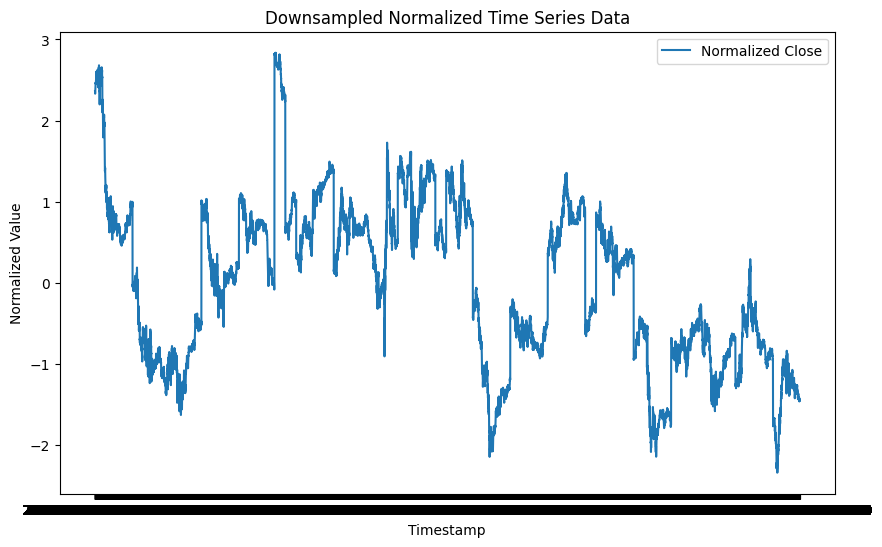

In [6]:

print("Ploting the data....")

# Downsample the data
# downsampled_data_norm = data_norm.resample('1D', on='timestamp').mean()

# Plot the downsampled data
plt.figure(figsize=(10, 6))
# plt.plot(data_norm['timestamp'], data_norm['open'], label='Normalized Open')
# plt.plot(data_norm['timestamp'], data_norm['high'], label='Normalized High')
# plt.plot(data_norm['timestamp'], data_norm['low'], label='Normalized Low')
plt.plot(data_norm['timestamp'], data_norm['close'], label='Normalized Close')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Value')
plt.title('Downsampled Normalized Time Series Data')
plt.legend()
plt.show()

### move data to tensor gpu

In [9]:
# Convert DataFrame to PyTorch tensor and move to GPU
data_tensor = torch.tensor(data_norm[['open', 'high', 'low', 'close']].values, dtype=torch.float32).unsqueeze(0).to(device)  # Add batch dimension

In [10]:

# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Taking the output from the last time step
        return out

# Parameters
input_size = 4  # Number of features (open, high, low, close)
hidden_size = 32  # Number of LSTM units
num_layers = 2  # Number of LSTM layers
output_size = 4  # Number of output classes (same as input size for reconstruction)

# Instantiate the model and move to GPU
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 1000
losses = []
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(data_tensor)
    loss = criterion(outputs, data_tensor)  # MSE loss
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())  # Store the loss value for visualization
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    print("Ploting the result")
    # Visualize the reconstruction of the time series at each epoch
    if (epoch+1) % 100 == 0:
        with torch.no_grad():  # We don't need gradients for visualization
            reconstructed_data = outputs.squeeze(0).cpu().numpy()  # Move data to CPU for visualization
            original_data = data_tensor.squeeze(0).cpu().numpy()  # Move data to CPU for visualization
            plt.figure(figsize=(10, 6))
            plt.plot(original_data[:, 0], label='Original Open')
            plt.plot(original_data[:, 1], label='Original High')
            plt.plot(original_data[:, 2], label='Original Low')
            plt.plot(original_data[:, 3], label='Original Close')
            plt.plot(reconstructed_data[:, 0], label='Reconstructed Open')
            plt.plot(reconstructed_data[:, 1], label='Reconstructed High')
            plt.plot(reconstructed_data[:, 2], label='Reconstructed Low')
            plt.plot(reconstructed_data[:, 3], label='Reconstructed Close')
            plt.title(f'Reconstruction at Epoch {epoch+1}')
            plt.xlabel('Time Step')
            plt.ylabel('Normalized Value')
            plt.legend()
            plt.show()

# Visualize the loss over epochs
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


c:\Users\ACER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 322637, 4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the result
Ploting the 